## <center> Polytechnique Montréal <br> Département Génie Informatique et Génie Logiciel <br>  LOG6308 - Systèmes de recommandations <br> </center>

## <center> TP3 : Systèmes de recommandation et réseaux de neurones </center>

L'objectif du TP3 est de vous familiariser avec les réseaux de neurones et la librairie Pytorch.
C'est pourquoi nous vous proposons d'effectuer des recommandations de films sur la base de données que vous connaissez bien maintenant : [MovieLens 100k](https://grouplens.org/datasets/movielens/).<br>


Le travail doit être fait en **équipe de deux**.

## Identification de l'équipe: B2_eq13

### Groupe de laboratoire: B2

### Equipe numéro : 13

### Membres:

Ettahri Mahacine (2312965) <br>
Li Xuewei (1879356)

<br>

**Nature de la contribution:**

- Mahacine Ettahri 2312965 (50% de contribution. Nature de la contribution : Elle a réalisé tous les excercice du tp individuellement comme chaque coéquipière. Puis les codes réalisé ont été comparé avec les autres membres pour valider les réponses obtenues. Finalement, une version propre du tp a été réalisée ensemble en combinant le code des deux coéquipières.)
- Xuewei Li 1879356 (50% de contribution. Nature de la contribution : Elle a réalisé tous les excercice du tp individuellement comme chaque coéquipière. Puis les codes réalisé ont été comparé avec les autres membres pour valider les réponses obtenues. Finalement, une version propre du tp a été réalisée ensemble en combinant le code des deux coéquipières.)

### Enoncé du TP

Ce notebook se trouve sous l'énoncé général du TP au lien [cours.polymtl.ca/MDesmarais/log6308/20251/Tp/tp3.html](https://cours.polymtl.ca/MDesmarais/log6308/20251/Tp/tp3.html).  Les données sont accessibles de ce lien.<br>

### Jeux de données

Vous avez 3 fichiers à votre disposition:

- 'Data/votes.csv': Matrice de données de 100 000 votes faits par 943 utilisateurs et portant sur 1682 items.
    - **user.id**: Indentifiant de l'utilisateur
    - **item.id**: Identifiant de l'item/film
    - **rating**: vote attribué à l'item par l'utilisateur
    - **timestamp**: Date d'enregistrement du vote (à ignorer pour ce TP)
- 'Data/items.csv': Matrice de données sur les films
    - **movie.id**: Identifiant du film
    - **movie.title**: Nom du film
    - **release.date**: Date de sortie
    - **video.release.date**: Date de sortie de la video
    - **IMDb.URL**: Lien vers le film
    - les 19 autres champs sont les categories des films qui sont les suivantes:
        "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
- 'Data/u.csv': Matrice de données sur les utilisateurs
    - **id**: Identififiant de l'utilisateurs
    - **age**: Age de l'utilisateur
    - **gender**: Sexe de l'utilisateur
    - **job**: Emploi de l'utilisateur
    - **zip**: ZIP Code

Attention aux espaces et à la casse des differents champs.

### Librairies permises

- numpy
- pandas
- pytorch
- seaborn
- matplotlib
- scikit-learn

Note: on ne doit pas importer d'autres librairies sans confirmer avec le chargé de laboratoire au préalable.  


### Rédaction et remise du rapport

- Ce notebook constitue à la fois votre code et votre rapport. Il contient un squelette pour guider votre travail.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte.

- <u>**IMPORTANT**</u> Remettez le ZIP contenant les données et le notebook sur Moodle avec le nom `<Groupe>_eq<Numero_Equipe>.ipynb` pour le notebook et `<Groupe>_eq<Numero_Equipe>.zip` pour le zip. Si vous décidez de rédiger un rapport, vous devez alors aussi inclure un fichier PDF



### CRITÈRES

- La démarche est valide et bien expliquée
- Les réponses sont correctes et commentées
- L'implémentation est performante et repose sur le calcul linéaire lorsqu'approprié
- La présentation est soignée et bien rédigée

### CODE D’HONNEUR

- __Règle 1__:  le plagiat de code est bien évidemment interdit. Toute utilisation de code doit être référencée adéquatement. Vous __ne pouvez pas__ soumettre un code écrit par quelqu’un d’autre.

- __Règle 2__: vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe ou incorporer leur code dans votre TP.

- __Règle 3__:  vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.

In [1]:
import os
import pprint
import tempfile

from tqdm import tqdm
from typing import Dict, Text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

plt.style.use('dark_background')

In [2]:
# Chargement des données (consultez https://cours.polymtl.ca/MDesmarais/log6308/20251/Tp/tp3.html)
movie_path = 'Data/items.csv'
user_path  = 'Data/user.csv'
votes_path = 'Data/votes.csv'

movie_feat = pd.read_csv(movie_path, sep =',')
user_feat  = pd.read_csv(user_path, sep =',')
votes_df   = pd.read_csv(votes_path, sep =',')
votes_df   = votes_df.astype('float32')
votes_df   = votes_df.rename(columns={'user.id': 'user_id', 'item.id': 'movie_id', 'rating': 'user_rating', 'timestamp': 'timestamp'})

In [3]:
votes_df

,user_id,movie_id,user_rating,timestamp
0,196.0,242.0,3.0,881250944.0
1,186.0,302.0,3.0,891717760.0
2,22.0,377.0,1.0,878887104.0
3,244.0,51.0,2.0,880606912.0
4,166.0,346.0,1.0,886397568.0
...,...,...,...,...
99995,880.0,476.0,3.0,880175424.0
99996,716.0,204.0,5.0,879795520.0
99997,276.0,1090.0,1.0,874795776.0
99998,13.0,225.0,2.0,882399168.0


# Question 1 (7 points)

a ) Implémentez un réseau de neurones version "Two towers". Vous devez calculer les plongements (embeddings) utilisateur et les plongements items. La prédiction du modèle (output) sera le produit scalaire des plongements utilisateurs avec les plongements items.

b ) Calculez la RMSE et la MAE pour déterminer la performance de votre modèle. Comparez vos résultats avec ceux des méthodes étudiées dans les TP 1 et 2.

c ) Choisissez le nombre d'epoch optimal avec un early-stopping.

d ) Afficher une courbe de l'évolution de la RMSE sur l'ensemble d'entrainement et de test.

e ) Quel type d'approche ce modèle représente-t-il ? (collaboratif, contenu ou hybride)

Aide : Votre modèle Two towers devra contenir les composantes suivants : Biais U-I , Dropout, Produit scalaire des embeddings, concaténation du produit scalaire avecle Biais et ajout d'une couche dense (fully connected) à la sortie.

Résultats attendus : on devrait obtenir aux alentours de 0.92-0.95 de RMSE sur l'ensemble de test après entrainement.

### Division des données en ensembles d'entraînement et de test

In [4]:
from sklearn.model_selection import train_test_split

# Division en ensemble d'entraînement et de test
train_df, test_df = train_test_split(votes_df, test_size=0.2, random_state=42)

### Création d'un Dataset PyTorch

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class MovieLensDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user_id = int(self.data.iloc[idx]['user_id'])
        movie_id = int(self.data.iloc[idx]['movie_id'])
        vote = self.data.iloc[idx]['user_rating']
        return user_id, movie_id, vote

#TODO Initialisation de l'ensemble d'entrainement et de test
train_dataset = MovieLensDataset(train_df)
test_dataset = MovieLensDataset(test_df)
#End TODO

### Création des DataLoader

In [6]:
from torch.utils.data import DataLoader

torch.manual_seed(42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### a) Définition du modèle

In [7]:
class MovieLensModelWithBiasPyTorch(nn.Module):
    def __init__(self, embedding_dimension, num_users, num_movies, min_vote=1, max_vote=5):
        super(MovieLensModelWithBiasPyTorch, self).__init__()
        self.min_vote = min_vote
        self.max_vote = max_vote

        # Créer des couches d'embeddings pour les utilisateurs et les items
        self.users_embedding = nn.Embedding(num_users, embedding_dimension)
        self.items_embedding = nn.Embedding(num_movies, embedding_dimension)

        # Créer des plongement pour les termes de biais pour les utilisateurs et les items
        self.user_bias = nn.Embedding(num_users,1)
        self.item_bias = nn.Embedding(num_movies,1)

        # Créer des fonctions d'oubli pour les utilisateurs et les items
        self.user_dropout = nn.Dropout()
        self.item_dropout = nn.Dropout()

        # Créer une couche linéaire pour la prédiction du score à partir des ids des utilisateurs et des items
        self.fc = nn.Linear(3,1)


    def forward(self, user_ids, movie_ids):
        #TODO Compléter la fonction
        # Récupérer les embeddings de l'utilisateur et du film à partir de leurs ids
        user_emb = self.users_embedding(user_ids-1)
        item_emb = self.items_embedding(movie_ids-1)

        # Ajouter des abandon pour les embeddings (dropout)
        user_emb = self.user_dropout(user_emb)
        item_emb = self.item_dropout(item_emb)

        # Récupérer les termes de biais de l'utilisateur et du film
        user_biais = self.user_bias(user_ids-1)
        item_biais = self.item_bias(movie_ids-1)

        # Calculer le produit scalaire des embeddings
        dot_product = (user_emb * item_emb).sum(dim=1, keepdim=True)

        # Concaténer les embeddings des termes de biais avec le produit scalaire
        x = torch.cat((dot_product, user_biais, item_biais), dim=1)

        # Projeter la concaténation à travers une couche entièrement connectée
        x = self.fc(x)

        # Appliquer une activation sigmoïde
        pred = torch.sigmoid(x).squeeze()

        # Normaliser la sortie
        pred = pred * (self.max_vote - self.min_vote) + self.min_vote

        return pred


# Estimer le nombre d'utilisateurs et de films differents
num_users = len(votes_df['user_id'].unique())
num_movies = len(votes_df['movie_id'].unique())

# Initialiser le modèle à entraîner
# La taille du plongement a été testée avec différentes valeurs (ex, 32, 64 et 128), mais les erreurs RMSE et MAE obtenues restent similaires. 
# Ainsi, la taille de 32 est choisie pour des raisons d'efficacité.
embedding_dimension = 32
model = MovieLensModelWithBiasPyTorch(embedding_dimension, num_users, num_movies)
model

MovieLensModelWithBiasPyTorch(
  (users_embedding): Embedding(943, 32)
  (items_embedding): Embedding(1682, 32)
  (user_bias): Embedding(943, 1)
  (item_bias): Embedding(1682, 1)
  (user_dropout): Dropout(p=0.5, inplace=False)
  (item_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=3, out_features=1, bias=True)
)

### Entrainement du modèle

In [8]:
# Initialiser l'optimiseur, la fonction de perte et le scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_rmse_list, train_mae_list = [], []
test_rmse_list, test_mae_list = [], []
train_loss, test_loss = [], []

num_epochs = 50

model.train()
for epoch in range(num_epochs):
    # Mettre le modèle en mode entraînement
    model.train()
    train_predictions, train_actuals = [], []
    train_running_loss = 0.0

    # Parcourir les lots de données dans le train_loader
    for user_id, movie_id, vote in train_loader:
        # Réinitialiser les gradients
        optimizer.zero_grad()
    
        predictions = model(user_id, movie_id)
        train_predictions.extend(predictions.tolist())
        train_actuals.extend(vote)

        # Calculer la perte entre les prédictions et les valeurs réelles
        loss = criterion(predictions, vote.float())
        # Calculer les gradients pour la rétropropagation
        loss.backward()
        # Mettre à jour les paramètres du modèle
        optimizer.step()
        
        train_running_loss += loss.item()

    # Mettre à jour le taux d'apprentissage si nécessaire
    scheduler.step()

    print(f'Epoch {epoch}, Loss: {train_running_loss / len(train_loader)}')
    train_loss.append(train_running_loss / len(train_loader))

    # Calculer la RMSE pour l'entraînement
    train_rmse = np.sqrt(mean_squared_error(train_actuals, train_predictions))
    # Calculer la MAE pour l'entraînement
    train_mae = mean_absolute_error(train_actuals, train_predictions)
    train_rmse_list.append(train_rmse)
    train_mae_list.append(train_mae)

    # Mettre le modèle en mode évaluation
    model.eval()
    test_predictions, test_actuals = [], []
    test_running_loss = 0.0

    # Désactiver les gradients pendant l'évaluation
    with torch.no_grad():
         # Parcourir les lots de données dans le test_loader
        for user_id, movie_id, vote in test_loader:
            preds = model(user_id, movie_id)
            test_predictions.extend(preds)
            test_actuals.extend(vote)

            loss = criterion(preds, vote.float())
            test_running_loss += loss.item()

        test_loss.append(test_running_loss / len(test_loader))

        # Calculer la RMSE pour le test
        test_rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))
        # Calculer la MAE pour le test
        test_mae = mean_absolute_error(test_actuals, test_predictions)
        print(f'RMSE: {test_rmse}')
        print(f'MAE: {test_mae}')

        test_rmse_list.append(test_rmse)
        test_mae_list.append(test_mae)

Epoch 0, Loss: 1.6018274062871933
RMSE: 1.1222819089889526
MAE: 0.9404600858688354
Epoch 1, Loss: 1.2508946675658226
RMSE: 1.108273983001709
MAE: 0.9176693558692932
Epoch 2, Loss: 1.1915368275642395
RMSE: 1.0769202709197998
MAE: 0.8786099553108215
Epoch 3, Loss: 1.1188100911021233
RMSE: 1.0467983484268188
MAE: 0.8430136442184448
Epoch 4, Loss: 1.055414977312088
RMSE: 1.0212278366088867
MAE: 0.8197203874588013
Epoch 5, Loss: 1.0034770939350128
RMSE: 1.0010186433792114
MAE: 0.7982465028762817
Epoch 6, Loss: 0.9601987475633621
RMSE: 0.9856340289115906
MAE: 0.7841386198997498
Epoch 7, Loss: 0.9240422893881798
RMSE: 0.9737098217010498
MAE: 0.7736260890960693
Epoch 8, Loss: 0.8921202060580253
RMSE: 0.9656676650047302
MAE: 0.7652801871299744
Epoch 9, Loss: 0.865716335272789
RMSE: 0.9587010741233826
MAE: 0.7591155767440796
Epoch 10, Loss: 0.8387204326152802
RMSE: 0.9530953168869019
MAE: 0.7525811791419983
Epoch 11, Loss: 0.8161578997254372
RMSE: 0.9489012956619263
MAE: 0.7489492893218994
Epoch

b ) Calculez la RMSE et la MAE pour déterminer la performance de votre modèle. Argumentez vos résultats par rapport aux méthodes étudiées dans les TP 1 et 2 et les résultats obtenus.

In [9]:
print(f'RMSE_test moyenne (50 epochs): {np.mean(test_rmse_list)}')
print(f'MAE_test moyenne (50 epochs): {np.mean(test_mae_list)}')

RMSE_test moyenne (50 epochs): 0.9468868374824524
MAE_test moyenne (50 epochs): 0.7471771836280823


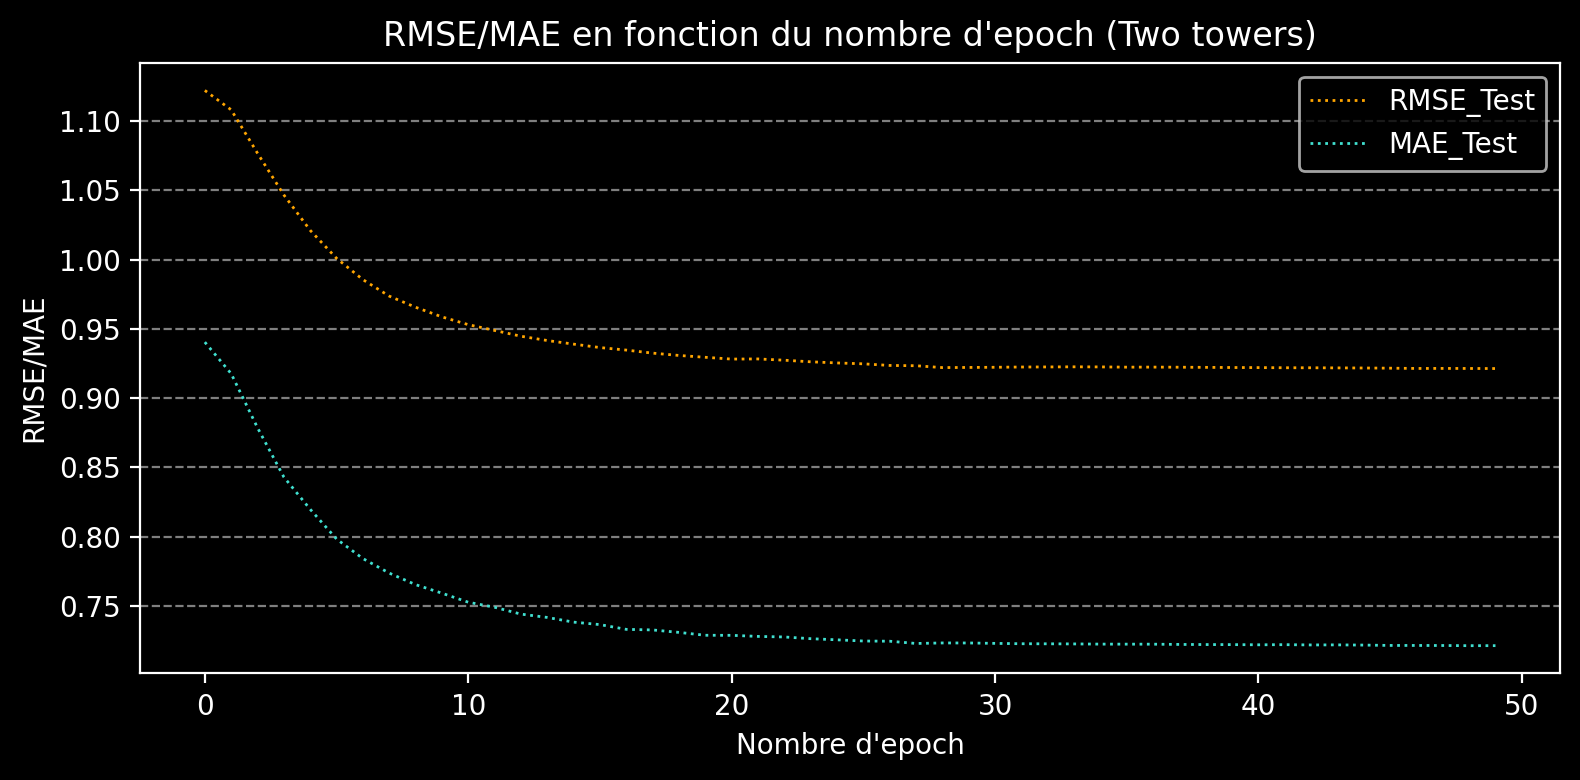

In [10]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

ax.plot(range(num_epochs), test_rmse_list, color='orange', linestyle = ':', linewidth=1, label="RMSE_Test")
ax.plot(range(num_epochs), test_mae_list, color='turquoise', linestyle = ':', linewidth=1, label="MAE_Test")

ax.set_ylabel('RMSE/MAE')
ax.set_xlabel('Nombre d\'epoch')
ax.set_title('RMSE/MAE en fonction du nombre d\'epoch (Two towers)')
ax.grid(True, axis='y', linestyle='--', color='white', alpha=0.5)
ax.legend()
plt.tight_layout()

# Analyse
Le modèle "two towers", basé sur les réseaux de neurones, atteint une performance de RMSE de 0,92 après environ 30 époques d'entraînement. Ce modèle fournit des résultats satisfaisants et se rapproche des performances du modèle des voisins rapprochés avec correction des biais du TP1. Cela démontre que le modèle est capable de capturer des relations complexes entre les utilisateurs et les items.

* Comparaison avec TP2 (SVD et KMeans avec corrélation de Pearson) : Les résultats pour SVD (avec validation croisée) dans le TP2 montrent des erreurs RMSE entre 0.94 et 0.98, ce qui est supérieur au RMSE de 0,92 obtenu dans le TP3. KMeans avec la corrélation de Pearson produit des erreurs dépassant 1 dans tous les réplis de validation croisée. On peut conclure que KMeans produit une dégradation des performances par rapport aux autres méthodes.


* Comparaison avec TP1 (voisins rapprochés et correction des biais) : On constate que l'utilisation des voisins rapprochés, combinée à la correction des biais, donne des résultats très intéressants. En particulier, la méthode basée sur les items rapprochés (RMSE = 0.88) surpasse légèrement les autres méthodes utilisées dans les TP2 et TP3.

### c ) Choisissez le nombre d'epoch optimal avec un early-stopping

In [11]:
# Définir la fonction pour entraîner une époque
def train_one_epoch(model, train_loader, optimizer, criterion, scheduler):
    model.train()
    train_running_loss = 0.0
    for user_id, movie_id, vote in train_loader:
        optimizer.zero_grad()
        outputs = model(user_id, movie_id)
        loss = criterion(outputs, vote.float())
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()

    scheduler.step()

    train_loss = train_running_loss / len(train_loader)

    return train_loss

# Définir la fonction pour tester une époque
def test_one_epoch(model, test_loader, criterion):
    model.eval()
    test_running_loss = 0.0
    test_actuals, test_predictions = [],[]

    with torch.no_grad():
        for user_id, movie_id, vote in test_loader:
            preds = model(user_id, movie_id)
            loss = criterion(preds, vote.float())
            test_running_loss += loss.item()

            test_predictions.extend(preds)
            test_actuals.extend(vote)

    test_loss = test_running_loss / len(test_loader)
    test_rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))
    test_mae = mean_absolute_error(test_actuals, test_predictions)

    return test_loss, test_rmse, test_mae

# Définir la classe pour déterminer le nombre d'epoch optimal avec un early-stopping
class CustomEarlyStopping:
    def __init__(self, max_epochs_without_improvement=3, min_improvement=1e-5):
        # Initialiser les paramètres de l'early stopping
        self.max_epochs_without_improvement = max_epochs_without_improvement
        self.min_improvement = min_improvement
        self.epochs_without_improvement = 0
        self.min_test_loss = float('inf')

    def custom_early_stopping(self, test_loss):
         # Vérifier si l'amélioration est suffisante
        improvement = test_loss < (self.min_test_loss - self.min_improvement)
        if improvement:
            # Réinitialiser le compteur d'époques sans amélioration et mettre à jour la meilleure perte
            self.epochs_without_improvement = 0
            self.min_test_loss = test_loss
        else:
            # Incrémenter le compteur d'époques sans amélioration
            self.epochs_without_improvement += 1
            
        return self.epochs_without_improvement >= self.max_epochs_without_improvement

torch.manual_seed(42)

# Redéfinir le modèle
model_early_stopped = MovieLensModelWithBiasPyTorch(embedding_dimension, num_users, num_movies)
optimizer = torch.optim.Adam(model_early_stopped.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
early_stopper = CustomEarlyStopping()

for epoch in np.arange(num_epochs):
    # Entraîner le modèle pour une époque
    train_loss = train_one_epoch(model_early_stopped, train_loader, optimizer, criterion, scheduler)
    # Tester le modèle pour cette époque
    test_loss, test_rmse, test_mae = test_one_epoch(model_early_stopped, test_loader, criterion)
    print(f'Epoch {epoch}, Loss: {train_loss}, RMSE: {test_rmse}, MAE: {test_mae} ')

    # Vérifier si l'early stopping doit être appliqué
    if early_stopper.custom_early_stopping(test_loss):
        print(f"Early stopping triggered at epoch {epoch}")
        break

Epoch 0, Loss: 1.6018274062871933, RMSE: 1.1222819089889526, MAE: 0.9404600858688354 
Epoch 1, Loss: 1.2508946675658226, RMSE: 1.108273983001709, MAE: 0.9176693558692932 
Epoch 2, Loss: 1.1915368275642395, RMSE: 1.0769202709197998, MAE: 0.8786099553108215 
Epoch 3, Loss: 1.1188100911021233, RMSE: 1.0467983484268188, MAE: 0.8430136442184448 
Epoch 4, Loss: 1.055414977312088, RMSE: 1.0212278366088867, MAE: 0.8197203874588013 
Epoch 5, Loss: 1.0034770939350128, RMSE: 1.0010186433792114, MAE: 0.7982465028762817 
Epoch 6, Loss: 0.9601987475633621, RMSE: 0.9856340289115906, MAE: 0.7841386198997498 
Epoch 7, Loss: 0.9240422893881798, RMSE: 0.9737098217010498, MAE: 0.7736260890960693 
Epoch 8, Loss: 0.8921202060580253, RMSE: 0.9656676650047302, MAE: 0.7652801871299744 
Epoch 9, Loss: 0.865716335272789, RMSE: 0.9587010741233826, MAE: 0.7591155767440796 
Epoch 10, Loss: 0.8387204326152802, RMSE: 0.9530953168869019, MAE: 0.7525811791419983 
Epoch 11, Loss: 0.8161578997254372, RMSE: 0.948901295661

### d ) Afficher une courbe de l'évolution de la RMSE sur l'ensemble d'entrainement et de test.




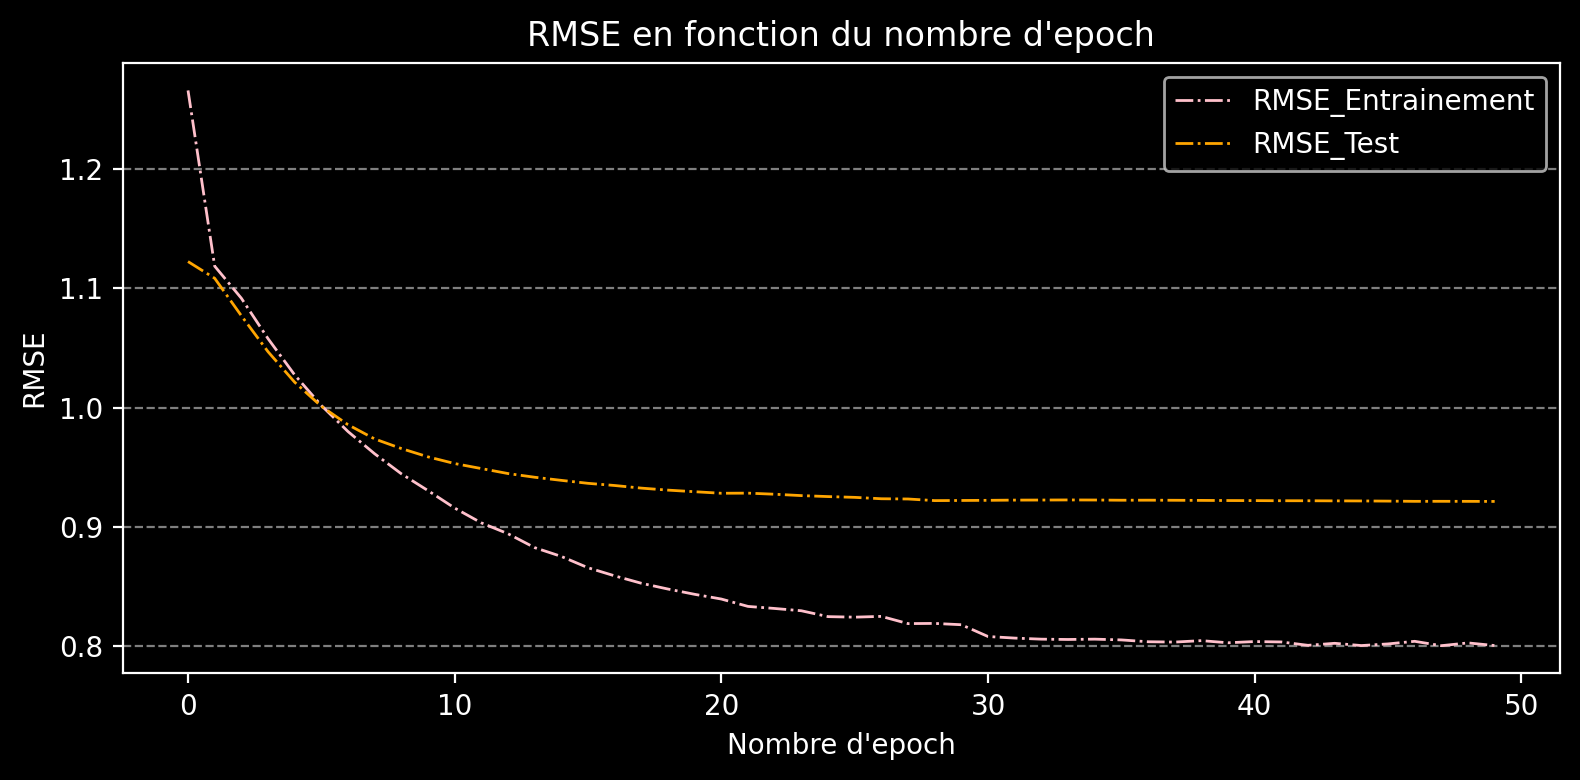

In [12]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

ax.plot(range(num_epochs), train_rmse_list, color='pink', linestyle = '-.', linewidth=1, label="RMSE_Entrainement")
ax.plot(range(num_epochs), test_rmse_list, color='orange', linestyle = '-.', linewidth=1, label="RMSE_Test")

ax.set_ylabel('RMSE')
ax.set_xlabel('Nombre d\'epoch')
ax.set_title('RMSE en fonction du nombre d\'epoch')
ax.grid(True, axis='y', linestyle='--', color='white', alpha=0.5)
ax.legend()
plt.tight_layout()

### e ) Quel type d'approche ce modèle représente t-il ? (collaboratif, contenu ou hybride)

Ce modèle adopte une approche collaborative en se fondant sur les évaluations (votes) des utilisateurs pour les films. Il exploite les plongements des utilisateurs et des films, sans toutefois intégrer leurs attributs spécifiques.

# Question 2 (11 points)

a ) Pour cette question on va implémenter un modèle similaire au modèle Two Towers de la question  1 mais au lieu d'effecuter le produit scalaire des embeddings on va se limiter à une simple concaténation.

b ) Ajouter l'âge et le sexe des utilisateurs aux plongements utilisateur à l'aide d'une concaténation. Observez-vous des différences ?

c ) Ajouter la catégorie aux plongements Items en utilisant une concaténation de la même manière. Est ce efficace ?

d ) Calculez la RMSE et la MAE de votre nouveau modèle.

c ) Quel type d'approche ce modèle représente t-il ? (collaboratif, contenu ou hybride) Justifiez.

Note : Vous n'êtes pas obligés d'implémenter 4 modèles à la suite vous pouvez répondre aux question a) , b) c) et d) à l'aide d'un seul modèle mais il est vivement recommandé de l'implémenter par étape et de s'assurer qu'il fonctionne bien à chaque étape (et de noter les résultats).

Les résultats de RMSE attendus sont d'environs 0.94

#### a)  Pour cette question on va implémenter un modèle similaire au modèle Two Towers de la question 1 mais au lieu d'effecuter le produit scalaire des embeddings on va se limiter à une simple concaténation.

In [13]:
class MovieLensModelWithBiasConcatPyTorch(nn.Module):
    def __init__(self, embedding_dimension, num_users, num_movies, min_vote=1, max_vote=5):
        super(MovieLensModelWithBiasConcatPyTorch, self).__init__()
        self.min_vote = min_vote
        self.max_vote = max_vote

        # Créer des couches d'embeddings pour les utilisateurs et les items
        self.users_embedding = nn.Embedding(num_users, embedding_dimension)
        self.items_embedding = nn.Embedding(num_movies, embedding_dimension)

        # Créer des plongement pour les termes de biais pour les utilisateurs et les items
        self.user_bias = nn.Embedding(num_users,1)
        self.item_bias = nn.Embedding(num_movies,1)

        self.dropout = nn.Dropout()  # Single dropout for both user and item embeddings

        self.fc = nn.Linear(embedding_dimension * 2 + 2, 1)  # Adjusted for concatenation


    def forward(self, user_ids, movie_ids):
        # Récupérer les embeddings de l'utilisateur et du film à partir de leurs ids
        user_emb = self.users_embedding(user_ids-1)
        item_emb = self.items_embedding(movie_ids-1)

        # Ajouter des abandon pour les embeddings (dropout)
        user_emb = self.dropout(user_emb)
        item_emb = self.dropout(item_emb)

        # Concaténer les embeddings de l'utilisateur et du film
        combined_emb = torch.cat((user_emb, item_emb), dim=1)

        # Récupérer les termes de biais de l'utilisateur et du film
        user_biais = self.user_bias(user_ids-1)
        item_biais = self.item_bias(movie_ids-1)

        # Concaténer l'embedding combiné et les biais
        x = torch.cat((combined_emb, user_biais, item_biais), dim=1)

        # Projeter la concaténation à travers une couche entièrement connectée
        x = self.fc(x)

        # Appliquer une activation sigmoïde
        pred = torch.sigmoid(x).squeeze()

        # Normaliser la sortie
        pred = pred * (self.max_vote - self.min_vote) + self.min_vote

        return pred


# Estimer le nombre d'utilisateurs et de films differents
num_users = len(votes_df['user_id'].unique())
num_movies = len(votes_df['movie_id'].unique())

# Initialiser le modèle à entraîner
embedding_dimension = 32
model_zero = MovieLensModelWithBiasConcatPyTorch(embedding_dimension, num_users, num_movies)
model_zero

MovieLensModelWithBiasConcatPyTorch(
  (users_embedding): Embedding(943, 32)
  (items_embedding): Embedding(1682, 32)
  (user_bias): Embedding(943, 1)
  (item_bias): Embedding(1682, 1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=66, out_features=1, bias=True)
)

In [14]:
optimizer = torch.optim.Adam(model_zero.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_rmse_list_a, train_mae_list_a = [], []
test_rmse_list_a, test_mae_list_a = [], []
train_loss_a, test_loss_a = [], []

num_epochs = 50

model_zero.train()
for epoch in range(num_epochs):
    model_zero.train()
    train_predictions_a, train_actuals_a = [], []
    train_running_loss_a = 0.0

    for user_id, movie_id, vote in train_loader:
        optimizer.zero_grad()
        predictions = model_zero(user_id, movie_id)
        train_predictions_a.extend(predictions.tolist())
        train_actuals_a.extend(vote)

        loss_a = criterion(predictions, vote.float())
        loss_a.backward()
        optimizer.step()
        train_running_loss_a += loss_a.item()

    scheduler.step()

    print(f'Epoch {epoch}, Loss: {train_running_loss_a / len(train_loader)}')
    train_loss_a.append(train_running_loss_a / len(train_loader))

    train_rmse_a = np.sqrt(mean_squared_error(train_actuals_a, train_predictions_a))
    train_mae_a = mean_absolute_error(train_actuals_a, train_predictions_a)
    train_rmse_list_a.append(train_rmse_a)
    train_mae_list_a.append(train_mae_a)


    model_zero.eval()
    test_predictions_a, test_actuals_a = [], []
    test_running_loss_a = 0.0

    with torch.no_grad():
        for user_id, movie_id, vote in test_loader:
            preds = model_zero(user_id, movie_id)
            test_predictions_a.extend(preds)
            test_actuals_a.extend(vote)

            loss_a = criterion(preds, vote.float())
            test_running_loss_a += loss_a.item()

        test_loss_a.append(test_running_loss_a / len(test_loader))

        test_rmse_a = np.sqrt(mean_squared_error(test_actuals_a, test_predictions_a))
        test_mae_a = mean_absolute_error(test_actuals_a, test_predictions_a)
        print(f'RMSE: {test_rmse_a}')
        print(f'MAE: {test_mae_a}')

        test_rmse_list_a.append(test_rmse_a)
        test_mae_list_a.append(test_mae_a)

Epoch 0, Loss: 1.2906636266827582
RMSE: 1.0632656812667847
MAE: 0.8706960678100586
Epoch 1, Loss: 1.0980673018097877
RMSE: 0.9940911531448364
MAE: 0.7961358428001404
Epoch 2, Loss: 1.010185394823551
RMSE: 0.9701460599899292
MAE: 0.7723013162612915
Epoch 3, Loss: 0.9629862164378166
RMSE: 0.9600962996482849
MAE: 0.7614634037017822
Epoch 4, Loss: 0.9394275333046913
RMSE: 0.9515947699546814
MAE: 0.7530617117881775
Epoch 5, Loss: 0.9212177927851677
RMSE: 0.9508354663848877
MAE: 0.7532020211219788
Epoch 6, Loss: 0.9086761384129525
RMSE: 0.9443473219871521
MAE: 0.7469355463981628
Epoch 7, Loss: 0.8984780360937119
RMSE: 0.9436211585998535
MAE: 0.7465704083442688
Epoch 8, Loss: 0.8922796960234642
RMSE: 0.9432132244110107
MAE: 0.7465739846229553
Epoch 9, Loss: 0.8860895278334617
RMSE: 0.9424746632575989
MAE: 0.7440524697303772
Epoch 10, Loss: 0.8808861651659012
RMSE: 0.9417871832847595
MAE: 0.743752121925354
Epoch 11, Loss: 0.8778762939810753
RMSE: 0.9420636892318726
MAE: 0.7453269362449646
Epoc

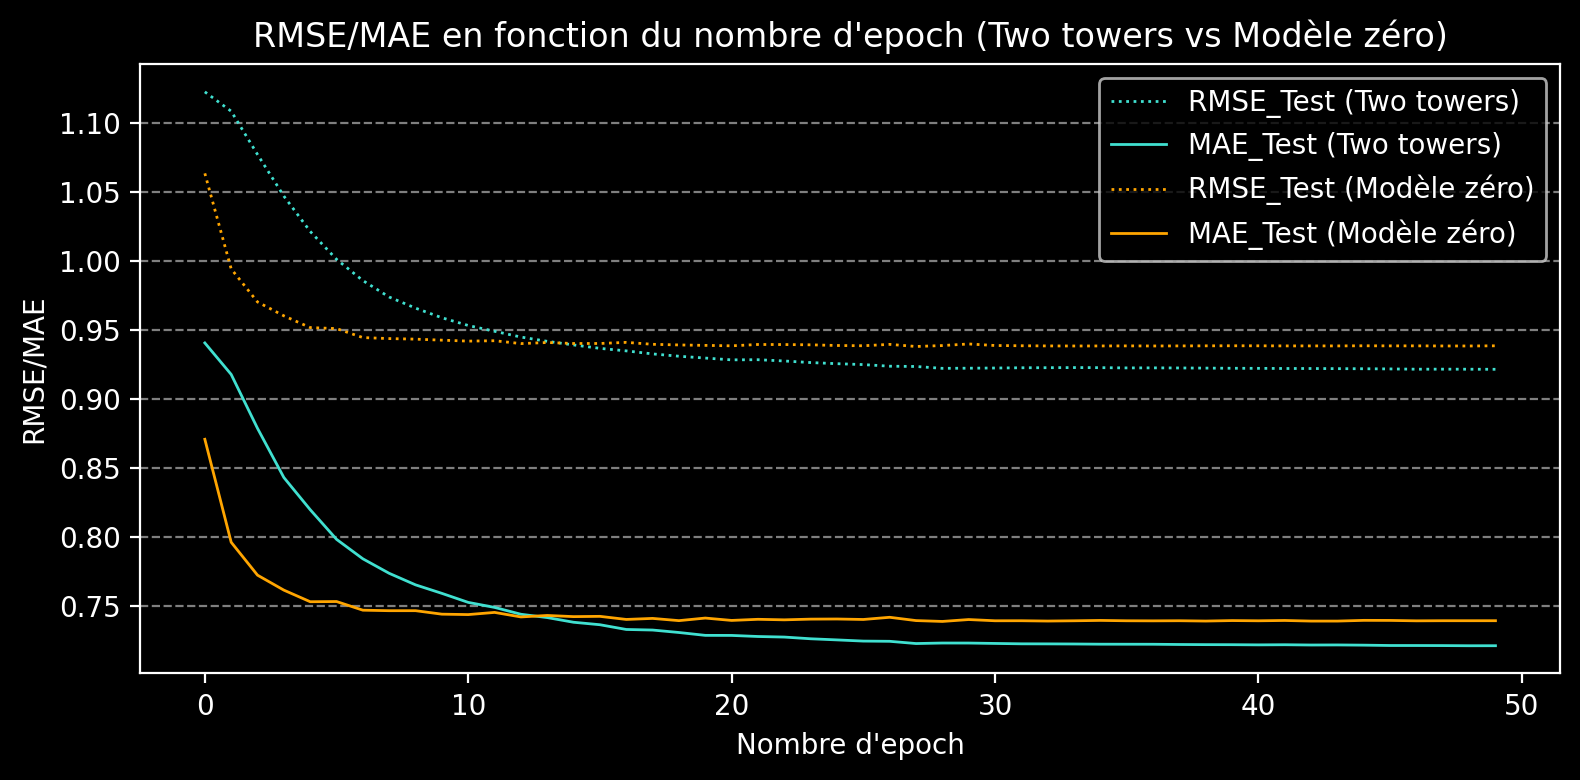

In [15]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

ax.plot(range(num_epochs), test_rmse_list, color='turquoise', linestyle = ':', linewidth=1, label="RMSE_Test (Two towers)")
ax.plot(range(num_epochs), test_mae_list, color='turquoise', linestyle = '-', linewidth=1, label="MAE_Test (Two towers)")
ax.plot(range(num_epochs), test_rmse_list_a, color='orange', linestyle = ':', linewidth=1, label="RMSE_Test (Modèle zéro)")
ax.plot(range(num_epochs), test_mae_list_a, color='orange', linestyle = '-', linewidth=1, label="MAE_Test (Modèle zéro)")

ax.set_ylabel('RMSE/MAE')
ax.set_xlabel('Nombre d\'epoch')
ax.set_title('RMSE/MAE en fonction du nombre d\'epoch (Two towers vs Modèle zéro)')
ax.grid(True, axis='y', linestyle='--', color='white', alpha=0.5)
ax.legend()
plt.tight_layout()

## Commentaires
- La différence entre le modèle utilisant un produit scalaire et celui reposant sur une simple concaténation n'est pas énorme. Cependant, si l'on souhaite privilégier l'un des deux, il serait préférable d'opter pour le premier modèle, car il génère des performances légèrement supérieures, comme en témoignent des RMSE et MAE de test plus bas.

#### b ) Ajouter l'âge et le sexe des utilisateurs aux plongements utilisateur à l'aide d'une concaténation. Observez-vous des différences avec les resultats précédents ?

In [16]:
class MovieLensDatasetQuestion2(Dataset):
    def __init__(self, df, user_feat, movie_feat):
        self.df = df
        self.user_feat = user_feat
        self.movie_feat = movie_feat

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user_id = int(self.df.iloc[idx]['user_id'])
        movie_id = int(self.df.iloc[idx]['movie_id'])
        vote = self.df.iloc[idx]['user_rating']
        
        # Récupérer l'âge de l'utilisateur
        age = int(self.user_feat[user_feat['id'] == user_id]['age'].values[0])
        # Récupérer le sexe de l'utilisateur : On encode le sexe en 1 pour masculin et 0 pour féminin
        gender = 1 if self.user_feat[user_feat['id'] == user_id]['gender'].values[0] == 'M' else 0
        
        return user_id, movie_id, vote, age, gender

In [17]:
train_dataset_user_feat = MovieLensDatasetQuestion2(train_df, user_feat, movie_feat)
test_dataset_user_feat = MovieLensDatasetQuestion2(test_df, user_feat, movie_feat)

torch.manual_seed(42)
train_loader_user_feat = DataLoader(train_dataset_user_feat, batch_size=64, shuffle=True)
test_loader_user_feat = DataLoader(test_dataset_user_feat, batch_size=64, shuffle=False)

In [18]:
class MovieLensModelWithBiasConcatPyTorch_user_feat(nn.Module):
    def __init__(self, embedding_dimension, num_users, num_movies, min_vote=1, max_vote=5):
        super(MovieLensModelWithBiasConcatPyTorch_user_feat, self).__init__()
        self.min_vote = min_vote
        self.max_vote = max_vote

        self.users_embedding = nn.Embedding(num_users, embedding_dimension)
        self.items_embedding = nn.Embedding(num_movies, embedding_dimension)

        self.user_bias = nn.Embedding(num_users,1)
        self.item_bias = nn.Embedding(num_movies,1)

        self.dropout = nn.Dropout()

        # Embedding_dimension * 2 (utilisateur et item) + 4 (âge, genre, biais utilisateur et biais item)
        self.fc = nn.Linear(embedding_dimension * 2 + 4, 1)


    def forward(self, user_ids, movie_ids, age, gender):
        user_emb = self.users_embedding(user_ids-1)
        item_emb = self.items_embedding(movie_ids-1)

        # Concaténer les embeddings de l'utilisateur, l'âge et le genre
        combined_user_emb = torch.cat((user_emb, age.unsqueeze(1), gender.unsqueeze(1)), dim=1)

        # Appliquer un dropout sur l'embedding combiné de l'utilisateur
        combined_user_emb = self.dropout(combined_user_emb)
        # Appliquer un dropout sur l'embedding de l'item
        item_emb = self.dropout(item_emb)

        combined_emb = torch.cat((combined_user_emb, item_emb), dim=1)

        user_biais = self.user_bias(user_ids-1)
        item_biais = self.item_bias(movie_ids-1)

        x = torch.cat((combined_emb, user_biais, item_biais), dim=1)

        x = self.fc(x)

        pred = torch.sigmoid(x).squeeze()

        pred = pred * (self.max_vote - self.min_vote) + self.min_vote

        return pred


num_users = len(votes_df['user_id'].unique())
num_movies = len(votes_df['movie_id'].unique())

embedding_dimension = 32
model_user_feat = MovieLensModelWithBiasConcatPyTorch_user_feat(embedding_dimension, num_users, num_movies)
model_user_feat

MovieLensModelWithBiasConcatPyTorch_user_feat(
  (users_embedding): Embedding(943, 32)
  (items_embedding): Embedding(1682, 32)
  (user_bias): Embedding(943, 1)
  (item_bias): Embedding(1682, 1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=68, out_features=1, bias=True)
)

In [19]:
optimizer = torch.optim.Adam(model_user_feat.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_rmse_list_b, train_mae_list_b = [], []
test_rmse_list_b, test_mae_list_b = [], []
train_loss_b, test_loss_b = [], []

num_epochs = 50

model_user_feat.train()
for epoch in range(num_epochs):
    model_user_feat.train()
    train_predictions_b, train_actuals_b = [], []
    train_running_loss_b = 0.0

    for user_id, movie_id, vote, age, gender in train_loader_user_feat:
        optimizer.zero_grad()
        predictions = model_user_feat(user_id, movie_id, age, gender)
        train_predictions_b.extend(predictions.tolist())
        train_actuals_b.extend(vote)

        loss_b = criterion(predictions, vote.float())
        loss_b.backward()
        optimizer.step()
        train_running_loss_b += loss_b.item()

    scheduler.step()

    print(f'Epoch {epoch}, Loss: {train_running_loss_b / len(train_loader_user_feat)}')
    train_loss_b.append(train_running_loss_b / len(train_loader_user_feat))

    train_rmse_b = np.sqrt(mean_squared_error(train_actuals_b, train_predictions_b))
    train_mae_b = mean_absolute_error(train_actuals_b, train_predictions_b)
    train_rmse_list_b.append(train_rmse_b)
    train_mae_list_b.append(train_mae_b)


    model_user_feat.eval()
    test_predictions_b, test_actuals_b = [], []
    test_running_loss_b = 0.0

    with torch.no_grad():
        for user_id, movie_id, vote, age, gender in test_loader_user_feat:
            preds = model_user_feat(user_id, movie_id, age, gender)
            test_predictions_b.extend(preds)
            test_actuals_b.extend(vote)

            loss_b = criterion(preds, vote.float())
            test_running_loss_b += loss_b.item()

        test_loss_b.append(test_running_loss_b / len(test_loader_user_feat))

        test_rmse_b = np.sqrt(mean_squared_error(test_actuals_b, test_predictions_b))
        test_mae_b = mean_absolute_error(test_actuals_b, test_predictions_b)
        print(f'RMSE: {test_rmse_b}')
        print(f'MAE: {test_mae_b}')

        test_rmse_list_b.append(test_rmse_b)
        test_mae_list_b.append(test_mae_b)

Epoch 0, Loss: 1.443692581510544
RMSE: 1.083142638206482
MAE: 0.894102931022644
Epoch 1, Loss: 1.1536597162246705
RMSE: 1.0257477760314941
MAE: 0.8327407240867615
Epoch 2, Loss: 1.059904402923584
RMSE: 0.987542450428009
MAE: 0.7904414534568787
Epoch 3, Loss: 1.0047689132928848
RMSE: 0.9697352647781372
MAE: 0.7689657211303711
Epoch 4, Loss: 0.9704606538534164
RMSE: 0.9615812301635742
MAE: 0.7688807845115662
Epoch 5, Loss: 0.9491082806348801
RMSE: 0.9528847932815552
MAE: 0.755510151386261
Epoch 6, Loss: 0.9334982177734376
RMSE: 0.9511030912399292
MAE: 0.751146674156189
Epoch 7, Loss: 0.9203648775577545
RMSE: 0.9513803720474243
MAE: 0.7474320530891418
Epoch 8, Loss: 0.9138492604017258
RMSE: 0.9446725249290466
MAE: 0.7478622198104858
Epoch 9, Loss: 0.905490684223175
RMSE: 0.9442157745361328
MAE: 0.7506574988365173
Epoch 10, Loss: 0.8949323817253113
RMSE: 0.9416939616203308
MAE: 0.7433339953422546
Epoch 11, Loss: 0.8939603837013245
RMSE: 0.9419215321540833
MAE: 0.7456461787223816
Epoch 12, 

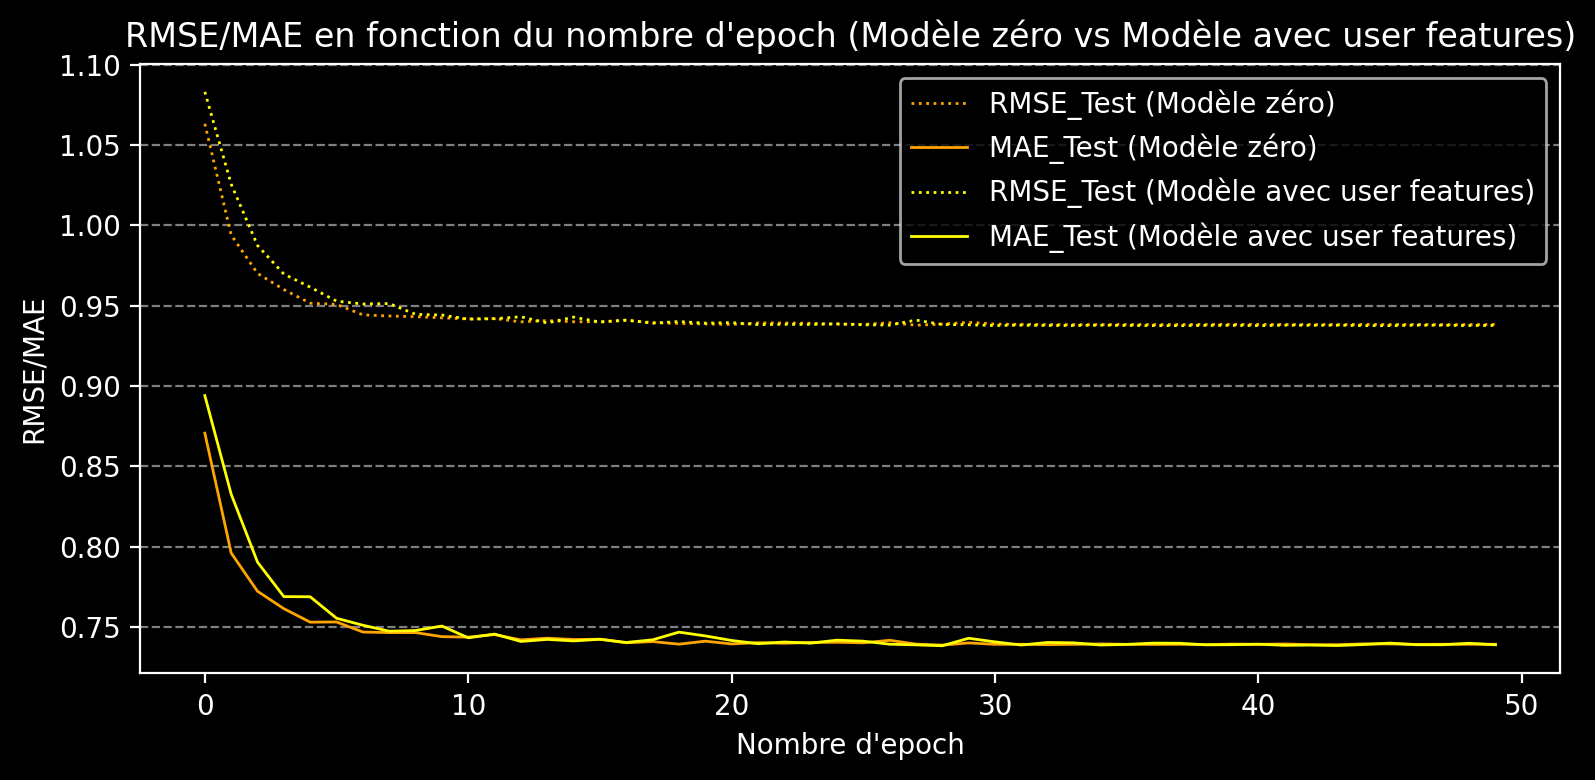

In [20]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

ax.plot(range(num_epochs), test_rmse_list_a, color='orange', linestyle = ':', linewidth=1, label="RMSE_Test (Modèle zéro)")
ax.plot(range(num_epochs), test_mae_list_a, color='orange', linestyle = '-', linewidth=1, label="MAE_Test (Modèle zéro)")
ax.plot(range(num_epochs), test_rmse_list_b, color='yellow', linestyle = ':', linewidth=1, label="RMSE_Test (Modèle avec user features)")
ax.plot(range(num_epochs), test_mae_list_b, color='yellow', linestyle = '-', linewidth=1, label="MAE_Test (Modèle avec user features)")

ax.set_ylabel('RMSE/MAE')
ax.set_xlabel('Nombre d\'epoch')
ax.set_title('RMSE/MAE en fonction du nombre d\'epoch (Modèle zéro vs Modèle avec user features)')
ax.grid(True, axis='y', linestyle='--', color='white', alpha=0.5)
ax.legend()
plt.tight_layout()

## Commentaires
- L'ajout de l'âge et du genre de l'utilisateur par concaténation n'entraîne qu'une variation minime des performances. Le RMSE sur l'ensemble de test demeure stable, avoisinant 0,94 (plus précisément 0,937).

#### c ) Ajouter la catégorie aux plongements Items en utilisant une concaténation de la même manière. Est ce efficace ?

In [21]:
class MovieLensDatasetQuestion3(Dataset):
    def __init__(self, df, user_feat, movie_feat):
        self.df = df
        self.user_feat = user_feat
        self.movie_feat = movie_feat

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user_id = int(self.df.iloc[idx]['user_id'])
        movie_id = int(self.df.iloc[idx]['movie_id'])
        vote = self.df.iloc[idx]['user_rating']
        age = int(self.user_feat[user_feat['id'] == user_id]['age'].values[0])
        gender = 1 if self.user_feat[user_feat['id'] == user_id]['gender'].values[0] == 'M' else 0
        
        # Extraire le(s) catégorie(s) du film et les transformer en one-hot encoding
        category = self.movie_feat[movie_feat['movie.id'] == movie_id].iloc[0, 5:].astype(int)
        category_one_hot = torch.tensor(category.values, dtype=torch.float32)
        
        return user_id, movie_id, vote, age, gender, category_one_hot

In [22]:
train_dataset_movie_feat = MovieLensDatasetQuestion3(train_df, user_feat, movie_feat)
test_dataset_movie_feat = MovieLensDatasetQuestion3(test_df, user_feat, movie_feat)

torch.manual_seed(42)
train_loader_movie_feat = DataLoader(train_dataset_movie_feat, batch_size=64, shuffle=True)
test_loader_movie_feat = DataLoader(test_dataset_movie_feat, batch_size=64, shuffle=False)

In [23]:
class MovieLensModelWithBiasConcatPyTorch_movie_feat(nn.Module):
    def __init__(self, embedding_dimension, num_users, num_movies, num_categories, min_vote=1, max_vote=5):
        super(MovieLensModelWithBiasConcatPyTorch_movie_feat, self).__init__()
        self.min_vote = min_vote
        self.max_vote = max_vote

        self.users_embedding = nn.Embedding(num_users, embedding_dimension)
        self.items_embedding = nn.Embedding(num_movies, embedding_dimension)

        self.user_bias = nn.Embedding(num_users,1)
        self.item_bias = nn.Embedding(num_movies,1)

        self.dropout = nn.Dropout()

        # Embedding_dimension * 2 (utilisateur et item) + nombre de catégories du film + 4 (âge, genre, biais utilisateur et biais item)
        self.fc = nn.Linear(embedding_dimension * 2 + num_categories + 4, 1)


    def forward(self, user_ids, movie_ids, user_ages, user_genders, movie_categories):
        user_emb = self.users_embedding(user_ids-1)
        item_emb = self.items_embedding(movie_ids-1)

        # Concaténer les embeddings de l'utilisateur, l'âge et le genre
        combined_user_emb = torch.cat((user_emb, user_ages.unsqueeze(1), user_genders.unsqueeze(1)), dim=1)
        # Appliquer un dropout sur l'embedding combiné de l'utilisateur
        combined_user_emb = self.dropout(combined_user_emb)

        # Concaténer les embeddings de l'item et le(s) catégorie(s) du film
        combined_item_emb = torch.cat((item_emb, movie_categories), dim=1)
        # Appliquer un dropout sur l'embedding combiné de l'item
        combined_item_emb = self.dropout(combined_item_emb)

        # Concaténer l'embedding combiné de l'utilisateur et l'embedding combiné de l'item
        combined_emb = torch.cat((combined_user_emb, combined_item_emb), dim=1)

        user_biais = self.user_bias(user_ids-1)
        item_biais = self.item_bias(movie_ids-1)

        x = torch.cat((combined_emb, user_biais, item_biais), dim=1)

        x = self.fc(x)

        pred = torch.sigmoid(x).squeeze()

        pred = pred * (self.max_vote - self.min_vote) + self.min_vote

        return pred


# Estimer le nombre d'utilisateurs, de films et de catégories de films différents
num_users = len(votes_df['user_id'].unique())
num_movies = len(votes_df['movie_id'].unique())
num_categories = movie_feat.iloc[:, 5:].shape[1]

embedding_dimension = 32
model_movie_feat = MovieLensModelWithBiasConcatPyTorch_movie_feat(embedding_dimension, num_users, num_movies, num_categories)
model_movie_feat

MovieLensModelWithBiasConcatPyTorch_movie_feat(
  (users_embedding): Embedding(943, 32)
  (items_embedding): Embedding(1682, 32)
  (user_bias): Embedding(943, 1)
  (item_bias): Embedding(1682, 1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=87, out_features=1, bias=True)
)

In [24]:
optimizer = torch.optim.Adam(model_movie_feat.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_rmse_list_c, train_mae_list_c = [], []
test_rmse_list_c, test_mae_list_c = [], []
train_loss_c, test_loss_c = [], []

num_epochs = 50

model_movie_feat.train()
for epoch in range(num_epochs):
    model_movie_feat.train()
    train_predictions_c, train_actuals_c = [], []
    train_running_loss_c = 0.0

    for user_id, movie_id, vote, age, gender, movie_categories in train_loader_movie_feat:
        optimizer.zero_grad()
        predictions = model_movie_feat(user_id, movie_id, age, gender, movie_categories)
        train_predictions_c.extend(predictions.tolist())
        train_actuals_c.extend(vote)

        loss_c = criterion(predictions, vote.float())
        loss_c.backward()
        optimizer.step()
        train_running_loss_c += loss_c.item()

    scheduler.step()

    print(f'Epoch {epoch}, Loss: {train_running_loss_c / len(train_loader_movie_feat)}')
    train_loss_c.append(train_running_loss_c / len(train_loader_movie_feat))

    train_rmse_c = np.sqrt(mean_squared_error(train_actuals_c, train_predictions_c))
    train_mae_c = mean_absolute_error(train_actuals_c, train_predictions_c)
    train_rmse_list_c.append(train_rmse_c)
    train_mae_list_c.append(train_mae_c)


    model_movie_feat.eval()
    test_predictions_c, test_actuals_c = [], []
    test_running_loss_c = 0.0

    with torch.no_grad():
        for user_id, movie_id, vote, age, gender, movie_categories in test_loader_movie_feat:
            preds = model_movie_feat(user_id, movie_id, age, gender, movie_categories)
            test_predictions_c.extend(preds)
            test_actuals_c.extend(vote)

            loss_c = criterion(preds, vote.float())
            test_running_loss_c += loss_c.item()

        test_loss_c.append(test_running_loss_c / len(test_loader_movie_feat))

        test_rmse_c = np.sqrt(mean_squared_error(test_actuals_c, test_predictions_c))
        test_mae_c = mean_absolute_error(test_actuals_c, test_predictions_c)
        print(f'RMSE: {test_rmse_c}')
        print(f'MAE: {test_mae_c}')

        test_rmse_list_c.append(test_rmse_c)
        test_mae_list_c.append(test_mae_c)

Epoch 0, Loss: 1.4152968041419982
RMSE: 1.0760185718536377
MAE: 0.8841283917427063
Epoch 1, Loss: 1.1437992448806762
RMSE: 1.0193215608596802
MAE: 0.8235435485839844
Epoch 2, Loss: 1.0528737416744232
RMSE: 0.9859641790390015
MAE: 0.7868977189064026
Epoch 3, Loss: 1.00237592959404
RMSE: 0.9688595533370972
MAE: 0.7686840295791626
Epoch 4, Loss: 0.971829691529274
RMSE: 0.9663311243057251
MAE: 0.760443389415741
Epoch 5, Loss: 0.9472059921741486
RMSE: 0.9518129825592041
MAE: 0.7546328902244568
Epoch 6, Loss: 0.935423944401741
RMSE: 0.9494971632957458
MAE: 0.7515630722045898
Epoch 7, Loss: 0.9207914020061493
RMSE: 0.9468094110488892
MAE: 0.7532411217689514
Epoch 8, Loss: 0.9138610512256622
RMSE: 0.9453893303871155
MAE: 0.745669424533844
Epoch 9, Loss: 0.9058148370742798
RMSE: 0.9446628093719482
MAE: 0.746152937412262
Epoch 10, Loss: 0.8996224903821946
RMSE: 0.942663848400116
MAE: 0.7453708648681641
Epoch 11, Loss: 0.8932832508802414
RMSE: 0.9448002576828003
MAE: 0.7434101700782776
Epoch 12, 

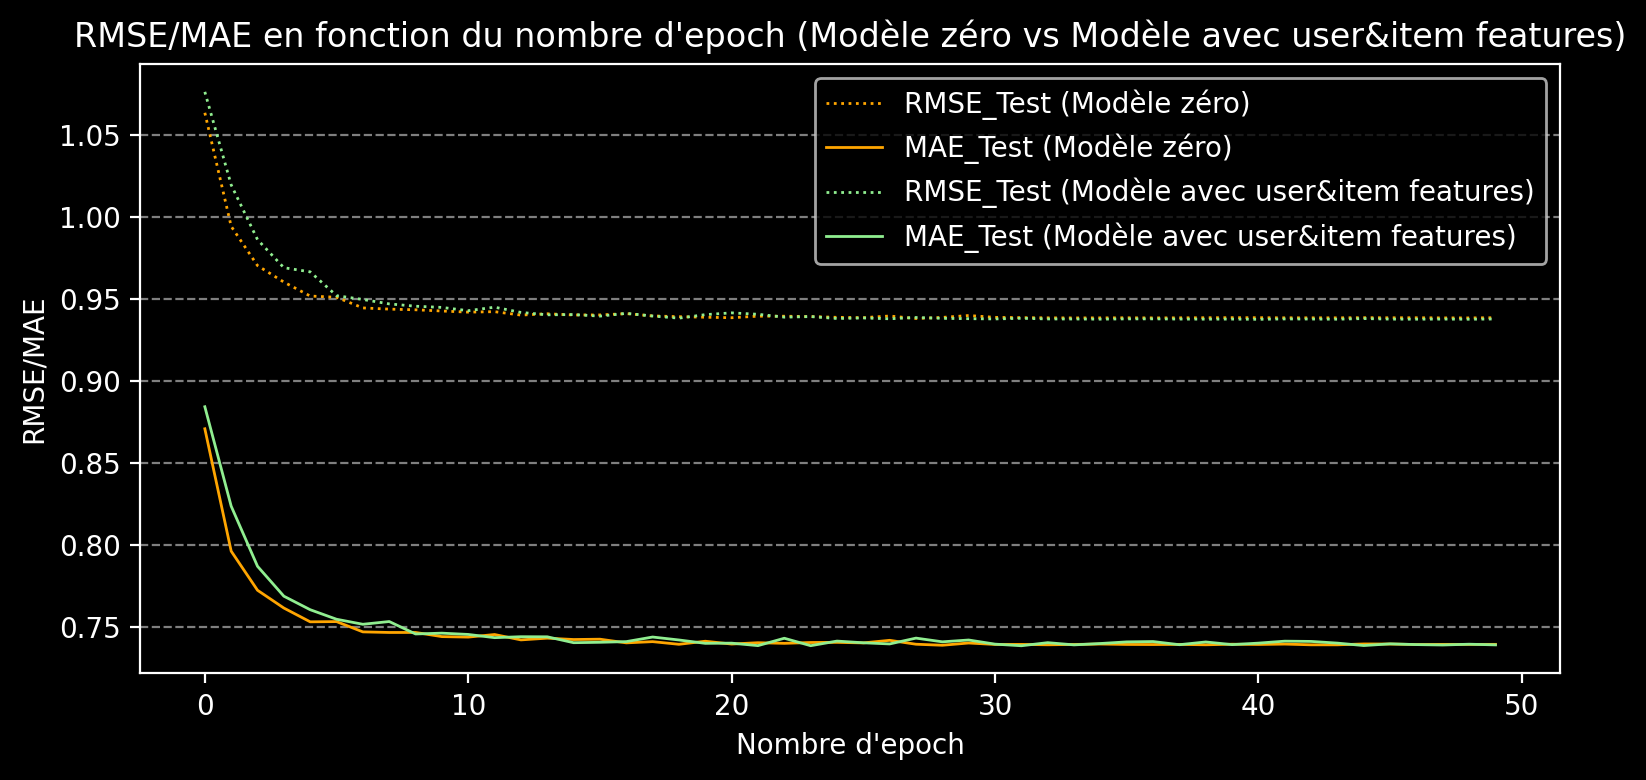

In [25]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

ax.plot(range(num_epochs), test_rmse_list_a, color='orange', linestyle = ':', linewidth=1, label="RMSE_Test (Modèle zéro)")
ax.plot(range(num_epochs), test_mae_list_a, color='orange', linestyle = '-', linewidth=1, label="MAE_Test (Modèle zéro)")
ax.plot(range(num_epochs), test_rmse_list_c, color='lightgreen', linestyle = ':', linewidth=1, label="RMSE_Test (Modèle avec user&item features)")
ax.plot(range(num_epochs), test_mae_list_c, color='lightgreen', linestyle = '-', linewidth=1, label="MAE_Test (Modèle avec user&item features)")

ax.set_ylabel('RMSE/MAE')
ax.set_xlabel('Nombre d\'epoch')
ax.set_title('RMSE/MAE en fonction du nombre d\'epoch (Modèle zéro vs Modèle avec user&item features)')
ax.grid(True, axis='y', linestyle='--', color='white', alpha=0.5)
ax.legend()
plt.tight_layout()

## Commentaires
- L'ajout des catégories de chaque film par concaténation n'améliore pas les performances par rapport au modèle précédent. Le RMSE de test reste toujours stable à environ 0,94. Plusieurs raisons peuvent expliquer cela, par exemple, les caractéristiques supplémentaires ne sont pas pertinentes ou le modèle n'est pas suffisamment sophistiqué pour les intégrer efficacement.

### d ) Calculez la RMSE et la MAE de votre nouveau modèle

In [26]:
print('Modèle zéro:')
print(f'RMSE_test moyenne (50 epochs): {np.mean(test_rmse_list_a)}')
print(f'MAE_test moyenne (50 epochs): {np.mean(test_mae_list_a)}', '\n')

print('Modèle avec user&item features:')
print(f'RMSE_test moyenne (50 epochs): {np.mean(test_rmse_list_c)}')
print(f'MAE_test moyenne (50 epochs): {np.mean(test_mae_list_c)}', '\n')

Modèle zéro:
RMSE_test moyenne (50 epochs): 0.9444426894187927
MAE_test moyenne (50 epochs): 0.7459763288497925 

Modèle avec user&item features:
RMSE_test moyenne (50 epochs): 0.9460444450378418
MAE_test moyenne (50 epochs): 0.7480430603027344 



### e ) Quel type d'approche ce modèle représente t-il ? (collaboratif, contenu ou hybride) Justifiez.


Ce modèle adopte une approche hybride en se basant à la fois sur les évaluations (votes) des utilisateurs pour les films (collaboratif) et sur leurs caractéristiques spécifiques (contenu). Il exploite les plongements des utilisateurs et des films, en tenant compte des attributs des utilisateurs (l'âge et le sexe) ainsi que des catégories des films.

## Question 3 (2 points)

Je suis un utilisateur homme de 27 ans ayant aimé les films suivants :
 - Toy Story (1995)
 - You So Crazy (1994)
 - B. Monkey (1998)
 - GoldenEye (1995)
 - Four Rooms (1995)

Quels sont les 3 autres films les plus suceptibles de me plaire selon le modèle de la question 1 ? et celui de la question 2 ?

Qu'en est il pour une femme de 52 ans qui a aimé exactement les mêmes films que moi ?  

## Prétraitement des données

In [27]:
films_list = ['Toy Story (1995)', 'You So Crazy (1994)', 'B. Monkey (1998)', 'GoldenEye (1995)', 'Four Rooms (1995)']
movie_id_list = []

# Parcourir chaque film de la liste pour extraire le movie.id correspondant
for film in films_list:
    movie_id = int(movie_feat[movie_feat[' movie.title'].str.contains(film, case=False, regex=False)]['movie.id'].values)
    movie_id_list.append(movie_id)

movie_feat[movie_feat['movie.id'].isin(movie_id_list)]

C:\Users\XueweiLi\AppData\Local\Temp\ipykernel_15056\3730749174.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  movie_id = int(movie_feat[movie_feat[' movie.title'].str.contains(film, case=False, regex=False)]['movie.id'].values)


,movie.id,movie.title,release.date,video.release.date,IMDb.URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Définir la fonction pour calculer la similarité cosinus entre deux matrices A et B
def cosine_similarity(A,B):
    col_norm_A = np.linalg.norm(A, axis=-1)[:, None]
    col_norm_B = np.expand_dims(np.linalg.norm(B, axis=-1), axis=0)
    cos_sim = np.dot(A, B.T) / np.dot(col_norm_A, col_norm_B)
    return cos_sim

# Générer la matrice de votes et effectuer le prétraitement
MUI = votes_df.pivot(index="user_id", columns="movie_id", values="user_rating")
MUI_numpy = MUI.to_numpy()
MUI_numpy = np.nan_to_num(MUI_numpy)

# Calculer la similarité cosinus entre le nouvel utilisateur et les utilisateurs existants
new_user = np.zeros((1, MUI_numpy.shape[1]))
new_user[0, [i-1 for i in movie_id_list]] = 5
u_cos = cosine_similarity(new_user, MUI_numpy)
np.fill_diagonal(u_cos, 0)

# Sélectionner les top_k utilisateurs similaires
def top_k_users(u_cos, top_k=10):
    u_cos_copy = u_cos.copy()
    return np.argsort(u_cos_copy[0])[-top_k:][::-1]

# Sélectionner les top_k utilisateurs similaires (en tenant en compte du sexe)
def top_k_users_with_gender(u_cos, gender, top_k=10):
    u_cos_copy = u_cos.copy()

    df = MUI.merge(user_feat, left_on='user_id', right_on='id')
    femme_id = df[df['gender'] == 'F']['id']
    homme_id = df[df['gender'] == 'M']['id']
    if gender == 'F':
        u_cos_copy[:, [i-1 for i in homme_id]] = 0
    else:
        u_cos_copy[:, [i-1 for i in femme_id]] = 0
    return np.argsort(u_cos_copy[0])[-top_k:][::-1]

top_k_users_femme = top_k_users_with_gender(u_cos, 'F')
top_k_users_homme = top_k_users_with_gender(u_cos, 'M')
top_k_users_global = top_k_users(u_cos)

print("10 utilisateurs les plus similaires(F) :", top_k_users_femme)
print("10 utilisateurs les plus similaires(M) :", top_k_users_homme)
print("10 utilisateurs les plus similaires(en général) :", top_k_users_global)

10 utilisateurs les plus similaires(F) : [208 725 821 894 389 201 758 119 750 522]
10 utilisateurs les plus similaires(M) : [713  92 579 440  80 792 156 677 133 548]
10 utilisateurs les plus similaires(en général) : [713  92 579 440  80 792 156 677 133 548]


## Prédiction avec le modèle de la question 1

In [29]:
# Convertir les ids des utilisateurs similaires en tensor
similar_user_ids = torch.tensor([i+1 for i in top_k_users_global], dtype=torch.long)
# Créer un tensor pour les ids des films (1 à num_movies)
movie_ids = torch.tensor(range(1, num_movies + 1), dtype=torch.long)

# Mettre le modèle en mode évaluation
model.eval()

# Pour chaque utilisateur similaire, prédire les évaluations (votes) pour tous les films
with torch.no_grad():
    user_ids = similar_user_ids.unsqueeze(1).expand(-1, movie_ids.shape[0])
    movie_ids_expanded = movie_ids.unsqueeze(0).expand(similar_user_ids.shape[0], -1)

    user_ids_flat = user_ids.flatten()
    movie_ids_flat = movie_ids_expanded.flatten()

    predictions_model_q1 = model(user_ids_flat, movie_ids_flat)

    predictions_model_q1 = predictions_model_q1.view(similar_user_ids.shape[0], movie_ids.shape[0])

# Obtenir les ids des top 3 films les mieux notés pour chaque utilisateur
top_k_scores, top_k_movie_indices = torch.topk(predictions_model_q1, k=3, dim=1)
top_k_movie_ids = top_k_movie_indices + 1

# Compter le nombre de fois où chaque film a été recommandé parmi les utilisateurs similaires
movie_id_counts = torch.bincount(top_k_movie_ids.flatten())

# Obtenir les ids des 3 films les plus recommandés
top_3_movie_ids = torch.topk(movie_id_counts, k=3).indices.tolist()

print(f'3 films recommandés (modèle Q1) pour un homme de 27 ans: {top_3_movie_ids}')
print(f'3 films recommandés (modèle Q1) pour une femme de 52 ans: {top_3_movie_ids}')

movie_feat[movie_feat['movie.id'].isin(top_3_movie_ids)]

3 films recommandés (modèle Q1) pour un homme de 27 ans: [64, 114, 12]
3 films recommandés (modèle Q1) pour une femme de 52 ans: [64, 114, 12]


,movie.id,movie.title,release.date,video.release.date,IMDb.URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
11,12,"Usual Suspects, The (1995)",14-Aug-1995,NaN,http://us.imdb.com/M/title-exact?Usual%20Suspe...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
63,64,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,114,Wallace & Gromit: The Best of Aardman Animatio...,05-Apr-1996,NaN,http://us.imdb.com/Title?Wallace+%26+Gromit%3A...,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Prédiction avec le modèle de la question 2c

In [30]:
# Convertir les ids des utilisateurs similaires en tensor
similar_user_ids = torch.tensor([i+1 for i in top_k_users_homme], dtype=torch.long)
# Créer un tensor pour les ids des films (1 à num_movies)
movie_ids = torch.tensor(range(1, num_movies + 1), dtype=torch.long)
# Définir l'âge et le genre de l'utilisateur
age = torch.tensor(27, dtype=torch.long)
gender = torch.tensor(1, dtype=torch.long)
# Extraire le(s) catégorie(s) du film et les transformer en one-hot encoding
category = movie_feat.iloc[movie_ids.numpy() - 1, 5:].astype(int)
category_one_hot = torch.tensor(category.values, dtype=torch.float32)

# Mettre le modèle en mode évaluation
model_movie_feat.eval()

# Pour chaque utilisateur similaire, prédire les évaluations (votes) pour tous les films
with torch.no_grad():
    user_ids = similar_user_ids.unsqueeze(1).expand(-1, movie_ids.shape[0])
    movie_ids_expanded = movie_ids.unsqueeze(0).expand(similar_user_ids.shape[0], -1)

    user_ids_flat = user_ids.flatten()
    movie_ids_flat = movie_ids_expanded.flatten()
    age_flat = age.expand(user_ids_flat.shape[0])
    gender_flat = gender.expand(user_ids_flat.shape[0])

    category_expanded = category_one_hot.unsqueeze(0).expand(similar_user_ids.shape[0], -1, -1)
    category_expanded_flat = category_expanded.reshape(-1, category_expanded.shape[-1])

    predictions_model_q2c = model_movie_feat(user_ids_flat, movie_ids_flat, age_flat, gender_flat, category_expanded_flat)
    predictions_model_q2c = predictions_model_q2c.view(similar_user_ids.shape[0], movie_ids.shape[0])

top_k_scores, top_k_movie_indices = torch.topk(predictions_model_q2c, k=3, dim=1)
top_k_movie_ids = top_k_movie_indices + 1

movie_id_counts = torch.bincount(top_k_movie_ids.flatten())

top_3_movie_ids = torch.topk(movie_id_counts, k=3).indices.tolist()

print(f'3 films recommandés (modèle Q2_c) pour un homme de 27 ans: {top_3_movie_ids}')

movie_feat[movie_feat['movie.id'].isin(top_3_movie_ids)]

3 films recommandés (modèle Q2_c) pour un homme de 27 ans: [408, 318, 114]


,movie.id,movie.title,release.date,video.release.date,IMDb.URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
113,114,Wallace & Gromit: The Best of Aardman Animatio...,05-Apr-1996,NaN,http://us.imdb.com/Title?Wallace+%26+Gromit%3A...,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
317,318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
407,408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [31]:
# Convertir les ids des utilisateurs similaires en tensor
similar_user_ids = torch.tensor([i+1 for i in top_k_users_femme], dtype=torch.long)
# Créer un tensor pour les ids des films (1 à num_movies)
movie_ids = torch.tensor(range(1, num_movies + 1), dtype=torch.long)
# Définir l'âge et le genre de l'utilisateur
age = torch.tensor(52, dtype=torch.long)
gender = torch.tensor(0, dtype=torch.long)

model_movie_feat.eval()

with torch.no_grad():
    user_ids = similar_user_ids.unsqueeze(1).expand(-1, movie_ids.shape[0])
    movie_ids_expanded = movie_ids.unsqueeze(0).expand(similar_user_ids.shape[0], -1)

    user_ids_flat = user_ids.flatten()
    movie_ids_flat = movie_ids_expanded.flatten()
    age_flat = age.expand(user_ids_flat.shape[0])
    gender_flat = gender.expand(user_ids_flat.shape[0])

    category_expanded = category_one_hot.unsqueeze(0).expand(similar_user_ids.shape[0], -1, -1)
    category_expanded_flat = category_expanded.reshape(-1, category_expanded.shape[-1])

    predictions_model_q2c = model_movie_feat(user_ids_flat, movie_ids_flat, age_flat, gender_flat, category_expanded_flat)
    predictions_model_q2c = predictions_model_q2c.view(similar_user_ids.shape[0], movie_ids.shape[0])

top_k_scores, top_k_movie_indices = torch.topk(predictions_model_q2c, k=3, dim=1)
top_k_movie_ids = top_k_movie_indices + 1

movie_id_counts = torch.bincount(top_k_movie_ids.flatten())

top_3_movie_ids = torch.topk(movie_id_counts, k=3).indices.tolist()

print(f'3 films recommandés (modèle Q2_c) pour une femme de 52 ans: {top_3_movie_ids}')

movie_feat[movie_feat['movie.id'].isin(top_3_movie_ids)]

3 films recommandés (modèle Q2_c) pour une femme de 52 ans: [408, 318, 114]


,movie.id,movie.title,release.date,video.release.date,IMDb.URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
113,114,Wallace & Gromit: The Best of Aardman Animatio...,05-Apr-1996,NaN,http://us.imdb.com/Title?Wallace+%26+Gromit%3A...,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
317,318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
407,408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## Commentaires sur les prédictions
Les deux modèles génèrent des recommandations différentes. Cependant, en comparant ces recommandations avec les films appréciés, on remarque que chaque modèle recommande au moins un film du genre animation (Wallace & Gromit et A Close Shave). De plus, tous les films recommandés datent des années 90. Tout cela s'aligne bien avec les préférences des utilisateurs.

Modèle Q1 : Ce modèle génère les mêmes prédictions pour des utilisateurs qui aiment exactement les mêmes films, malgré des caractéristiques différentes (un homme de 27 ans vs une femme de 52 ans). Ce comportement est attendu, car ce modèle est purement collaboratif et ne prend pas en compte les attributs des utilisateurs.

Modèle Q2_c : Bien que ce modèle prenne en compte les caractéristiques des utilisateurs (âge et genre) et des films (catégorie), il génère les mêmes prédictions pour des utilisateurs différents. Ce résultat n'est pas surprenant, car selon les erreurs calculées dans la question 2, on observe que l'ajout des caractéristiques des utilisateurs et des films ne permet pas d'améliorer la performance du modèle.